In [27]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('data/cpu_data_custom_orangepi.csv')

# Convert string representation of lists back to actual lists
df['features'] = df['features'].apply(ast.literal_eval)
df.reset_index(drop=True, inplace=True)

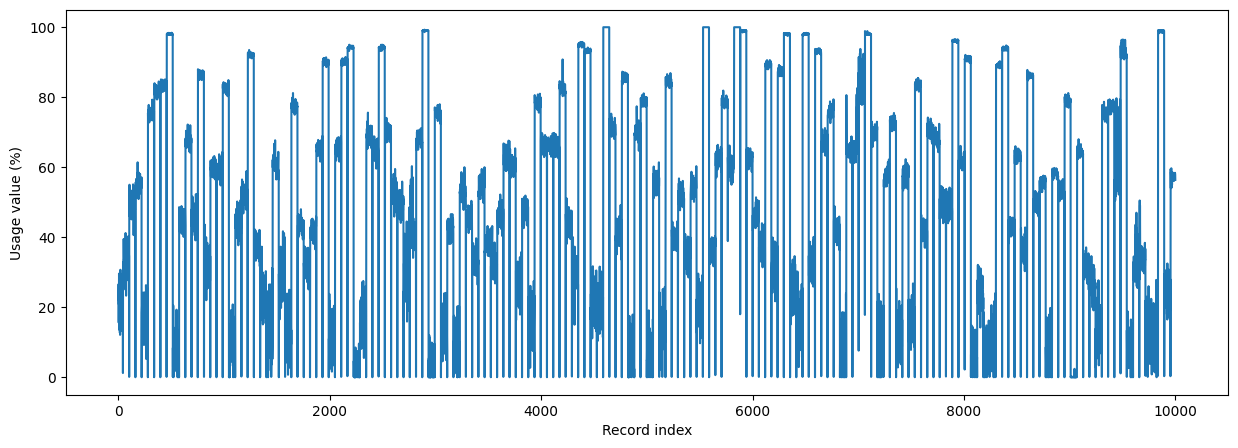

In [29]:
plt.figure(figsize=(15,5))
plt.plot(df.index[:10000], df['target'][:10000])
plt.xlabel('Record index')
plt.ylabel('Usage value (%)')
# plt.title('CPU Usage (%)')
plt.show()

In [30]:
task1_data = df[0:2000]
task2_data = df[3000:4000]
test_data = df[6000:6500]

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.fc(lstm_out.view(len(input), -1))
        return output[-1]

In [32]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        x = torch.tensor(sample['features'], dtype=torch.float32)
        y = torch.tensor(sample['target'], dtype=torch.float32)
        return x, y

In [33]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [34]:
def finetune_model(model, dataloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Set the model to training mode
        
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Last Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [35]:
def test_model(test_dataloader):
    test_running_loss = 0.0
    test_total_samples = 0
    test_absolute_errors = 0.0
    
    # Switch model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data in test_dataloader:
            inputs, labels = data
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss (MSE or MAE)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()
            
            # Calculate absolute error (MAE)
            test_absolute_error = torch.abs(outputs - labels)
            test_absolute_errors += test_absolute_error.sum().item()
            
            # Update total samples
            test_total_samples += labels.size(0)
    
    # Calculate Mean Absolute Error (MAE) on test dataset
    test_mean_absolute_error = test_absolute_errors / test_total_samples
    
    # Print loss and MAE on test dataset
    print(f'Test Loss: {test_running_loss/len(test_dataloader)}, Test MAE: {test_mean_absolute_error}')

In [36]:
input_size = 8  # Input size is the length of the input list
hidden_size = 16
output_size = 1
learning_rate = 0.001
epochs = 10

In [37]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1, shuffle=True)
# Train the model for task 1
train_model(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2477.717859850069
Epoch 2, Loss: 1394.7883930140101
Epoch 3, Loss: 814.2420657686168
Epoch 4, Loss: 482.41328130107667
Epoch 5, Loss: 289.27663035291783
Epoch 6, Loss: 179.17167286806298
Epoch 7, Loss: 114.99789739971668
Epoch 8, Loss: 80.80432419690885
Epoch 9, Loss: 70.66210488482018
Epoch 10, Loss: 55.43898887452874


In [39]:
task2_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=True)

In [40]:
test_model(test_dataloader)

Test Loss: 72.2445275263181, Test MAE: 6.6316488122940065


In [41]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=False)
# Finetune the model using task 2 data
finetune_model(model, task2_dataloader, criterion, optimizer, epochs)


======== Task 2 Training ========
Last Epoch 1, Loss: 54.49562776576016
Last Epoch 2, Loss: 56.27165515684204
Last Epoch 3, Loss: 49.8960234935841
Last Epoch 4, Loss: 47.5455574562595
Last Epoch 5, Loss: 57.29118111645372
Last Epoch 6, Loss: 50.62050945417375
Last Epoch 7, Loss: 48.13746179893392
Last Epoch 8, Loss: 63.25620545641152
Last Epoch 9, Loss: 66.88888570323337
Last Epoch 10, Loss: 50.970140618908914


In [42]:
test_model(test_dataloader)

Test Loss: 354.0760260896482, Test MAE: 15.758931089878082


# Handeling Catastophic Forgetting in Continual Learning

In [58]:
# Initialize the rehearsal buffer
rehearsal_buffer = []
def train_model_with_rehearsal(model, dataloader, criterion, optimizer, epochs=10, finetune='No'):
    global rehearsal_buffer
    if finetune=='Yes':
        model.train()  # Set the model to training mode
        
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            
            # Include samples from the rehearsal buffer
            if len(rehearsal_buffer) > 0:
                rehearsal_samples = random.sample(rehearsal_buffer, min(len(rehearsal_buffer), len(inputs)))
                for rehearsal_input, rehearsal_label in rehearsal_samples:
                    inputs = torch.cat((inputs, rehearsal_input.unsqueeze(0)), dim=0)
                    labels = torch.cat((labels, rehearsal_label.unsqueeze(0)), dim=0)
                    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

In [63]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1)
# Train the model for task 1
train_model_with_rehearsal(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2307.9730629067476
Epoch 2, Loss: 1282.6158089624876
Epoch 3, Loss: 814.2720254771363
Epoch 4, Loss: 508.19966843340126
Epoch 5, Loss: 324.89122106196737
Epoch 6, Loss: 267.62234587584123
Epoch 7, Loss: 144.2708492474562
Epoch 8, Loss: 93.99734662133245
Epoch 9, Loss: 69.38899297682481
Epoch 10, Loss: 62.31175922883649


In [65]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1)
# Finetune the model using task 2 data
train_model_with_rehearsal(model, task2_dataloader, criterion, optimizer, epochs, finetune='Yes')


======== Task 2 Training ========
Epoch 1, Loss: 59.64738675261143
Epoch 2, Loss: 53.27208903650493
Epoch 3, Loss: 50.92486299865613
Epoch 4, Loss: 49.226528182133116
Epoch 5, Loss: 61.22169415699927
Epoch 6, Loss: 48.14448839970888
Epoch 7, Loss: 49.28450825990993
Epoch 8, Loss: 46.88354528881569
Epoch 9, Loss: 46.83641939562262
Epoch 10, Loss: 53.89984892827696


In [66]:
test_model(test_dataloader)

Test Loss: 188.16015137121732, Test MAE: 11.889616010189057


# Updateting with rehearsal_ratio

In [75]:
# Initialize the rehearsal buffer
rehearsal_buffer = []

def train_model_with_rehearsal_ratio(model, dataloader, criterion, optimizer, epochs=10, rehearsal_ratio=0.5, finetune='No'):
    global rehearsal_buffer

    if finetune=='Yes':
        model.train()  # Set the model to training mode
        
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            
            # Include samples from the rehearsal buffer
            if len(rehearsal_buffer) > 0 and random.random() < rehearsal_ratio:
                rehearsal_samples = random.sample(rehearsal_buffer, min(len(rehearsal_buffer), len(inputs)))
                for rehearsal_input, rehearsal_label in rehearsal_samples:
                    inputs = torch.cat((inputs, rehearsal_input.unsqueeze(0)), dim=0)
                    labels = torch.cat((labels, rehearsal_label.unsqueeze(0)), dim=0)
                    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')


In [76]:
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [77]:
# Training for task 1
print("======== Task 1 Training ========")
task1_dataset = CustomDataset(task1_data)
task1_dataloader = DataLoader(task1_dataset, batch_size=1, shuffle=True)
train_model_with_rehearsal_ratio(model, task1_dataloader, criterion, optimizer, epochs)

======== Task 1 Training ========
Epoch 1, Loss: 2398.6794677072685
Epoch 2, Loss: 1248.191316556838
Epoch 3, Loss: 677.4291347627617
Epoch 4, Loss: 378.17165343101954
Epoch 5, Loss: 214.15197081286317
Epoch 6, Loss: 128.8208286019747
Epoch 7, Loss: 83.6013970768011
Epoch 8, Loss: 62.7569514679354
Epoch 9, Loss: 53.81721424100923
Epoch 10, Loss: 48.28240071201478


In [78]:
print("\n======== Task 2 Training ========")
task2_dataset = CustomDataset(task2_data)
task2_dataloader = DataLoader(task2_dataset, batch_size=1, shuffle=True)
# Finetune the model using task 2 data
train_model_with_rehearsal_ratio(model, task2_dataloader, criterion, optimizer, epochs, finetune='Yes')


======== Task 2 Training ========
Epoch 1, Loss: 49.06868282489432
Epoch 2, Loss: 44.410901595856686
Epoch 3, Loss: 43.28121965690971
Epoch 4, Loss: 43.85857274937333
Epoch 5, Loss: 43.46005366914139
Epoch 6, Loss: 41.947557424121825
Epoch 7, Loss: 39.91961061589623
Epoch 8, Loss: 39.80157068948727
Epoch 9, Loss: 38.791107305518146
Epoch 10, Loss: 38.35773162365299


In [79]:
test_model(test_dataloader)

Test Loss: 139.7184872527258, Test MAE: 9.678415427207947
